In [ ]:
!pip install transformers diffusers accelerate datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00


## Import Dataset

In [ ]:
from datasets import load_dataset
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Preprocess dataset

In [ ]:
from torchvision import transforms

image_size = 64
preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

In [ ]:
import torch
batch_size = 32

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images":images}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True
)

In [ ]:
batch = next(iter(train_dataloader))
print('Shape:', batch['images'].shape,
      '\nBounds:', batch['images'].min().item(), 'to', batch['images'].max().item())

Shape: torch.Size([32, 3, 64, 64]) 
Bounds: -0.9843137264251709 to 1.0


Check the shape

In [ ]:
from diffusers import DDPMScheduler
scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.02)
timesteps = torch.linspace(0, 999, 8).long()

x = batch['images'][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)

## Build the Model

In [ ]:
from diffusers import UNet2DModel

unet = UNet2DModel(
    in_channels=3,
    sample_size=64,
    block_out_channels=(64,128,256,512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D"
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    )
)

In [ ]:
with torch.no_grad():
    out = unet(noised_x, timestep=timesteps).sample

out.shape

torch.Size([8, 3, 64, 64])

## Training

In [ ]:
import torch.nn.functional as F
device = "cuda"
num_epochs = 50 # How many runs through the data should we do?
lr = 1e-4 # What learning rate should we use
unet = unet.to(device) # The model we're training (defined in the previous section)
optimizer = torch.optim.AdamW(unet.parameters(), lr=lr) # The optimizer
losses = [] # somewhere to store the loss values for later plotting

# Train the model (this takes a while!)
for epoch in range(num_epochs):
    for step, batch in enumerate(train_dataloader):

        # Load the input images
        clean_images = batch["images"].to(device)

        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (clean_images.shape[0],),
            device=clean_images.device,
        ).long()

        # Add noise to the clean images according timestep
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        noise_pred = unet(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise:
        loss = F.mse_loss(noise_pred, noise)

        # Store the loss for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward(loss)
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch}: loss={losses[-1]}")

Epoch 0: loss=0.17056381702423096
Epoch 1: loss=0.10094346851110458
Epoch 2: loss=0.10799332708120346
Epoch 3: loss=0.12123969197273254
Epoch 4: loss=0.07544992864131927
Epoch 5: loss=0.1302579641342163
Epoch 6: loss=0.08400877565145493
Epoch 7: loss=0.07889874279499054
Epoch 8: loss=0.08182328939437866
Epoch 9: loss=0.049215372651815414
Epoch 10: loss=0.05689718574285507
Epoch 11: loss=0.07737085223197937
Epoch 12: loss=0.07363582402467728
Epoch 13: loss=0.10461263358592987
Epoch 14: loss=0.04150570556521416
Epoch 15: loss=0.03741295635700226
Epoch 16: loss=0.10159166902303696
Epoch 17: loss=0.04309024661779404
Epoch 18: loss=0.06622651219367981
Epoch 19: loss=0.06012377142906189
Epoch 20: loss=0.03762900084257126
Epoch 21: loss=0.03851134330034256
Epoch 22: loss=0.10083463042974472
Epoch 23: loss=0.07816964387893677
Epoch 24: loss=0.030888361856341362
Epoch 25: loss=0.036953866481781006
Epoch 26: loss=0.06251120567321777
Epoch 27: loss=0.10792180150747299
Epoch 28: loss=0.02173011749

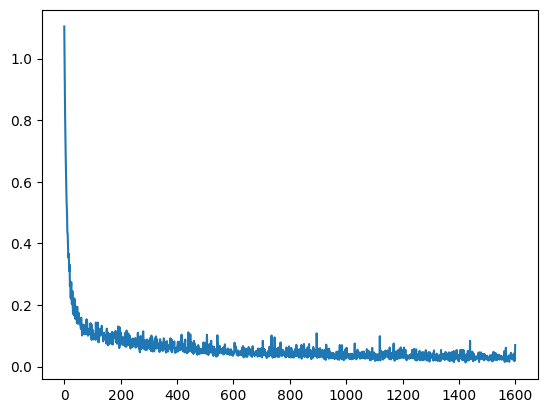

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)

## Testing

In [ ]:
from diffusers import DDPMPipeline

pipe = DDPMPipeline(unet, scheduler)
image = pipe().images[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

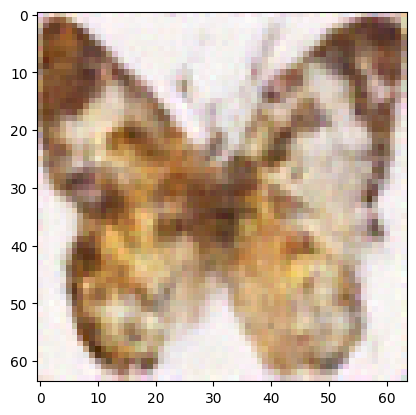

In [ ]:
plt.imshow(image)

## Upload to HuggingFace

In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [ ]:
pipe.push_to_hub("ddpm-butterflies-64", variant="fp16", private=True)

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/253M [00:00<?, ?B/s]

'https://huggingface.co/gnokit/ddpm-butterflies-64/tree/main/'

In [ ]:
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained("gnokit/ddpm-butterflies-64", use_safetensors=True, variant="fp16").to("cuda")

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
images = pipeline(batch_size=4).images

  0%|          | 0/1000 [00:00<?, ?it/s]

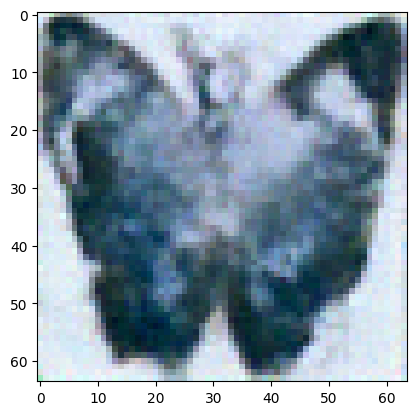

In [ ]:
plt.imshow(images[0])

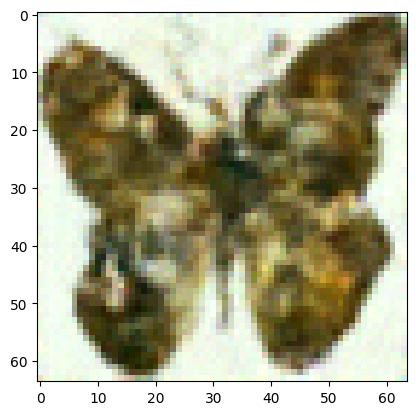

In [ ]:
plt.imshow(images[1])

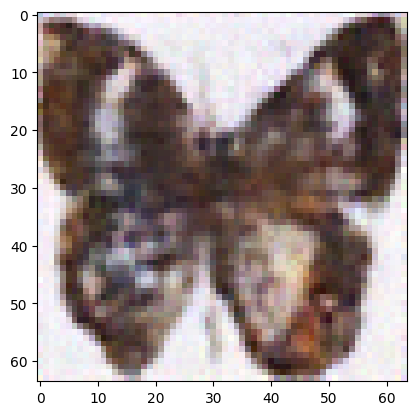

In [ ]:
plt.imshow(images[2])

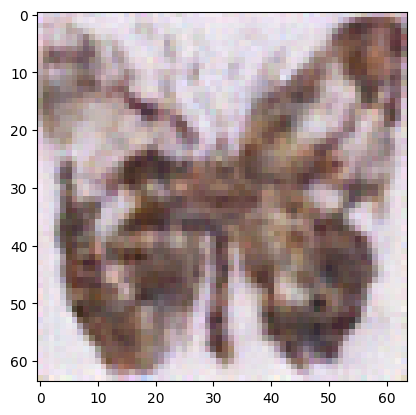

In [ ]:
plt.imshow(images[3])

In [ ]:
images[0].save("bf1.png")

In [ ]:
for idx, img in enumerate(images):
    img.save(f"bf-{idx}.png")